In [1]:
import warnings

warnings.filterwarnings(action='ignore')

import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from torch import nn
from torch.utils.data import random_split, DataLoader
from forest_cover_change_detection.dataloaders.change import ChangeDetectionDataset
from forest_cover_change_detection.models.fc_siam import FCSiam
from forest_cover_change_detection.trainer.train import Compile
from forest_cover_change_detection.metrics.accuracy import *

### Loading Data

In [2]:
data_set = ChangeDetectionDataset('../../data/annotated',
                                  '../../data/train.csv',
                                  concat=False,
                                  patched=False
                                  )

In [3]:
len(data_set)

334

torch.Size([3, 128, 128]) torch.Size([3, 128, 128]) torch.Size([128, 128])


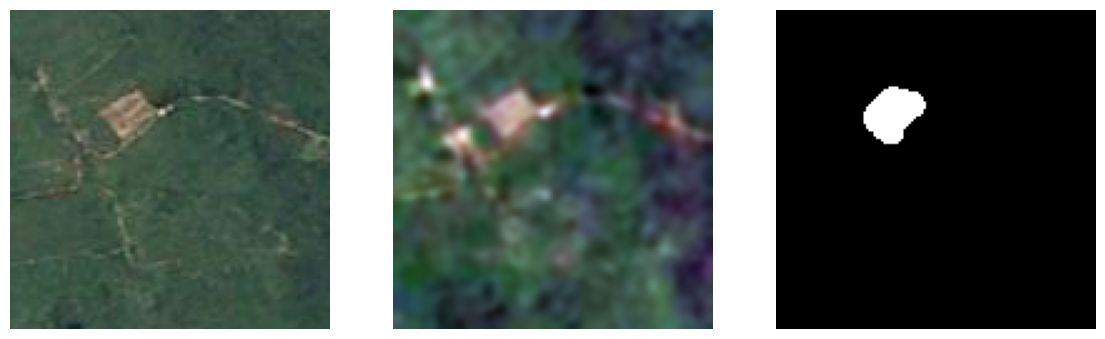

In [7]:
imgs, label = data_set[np.random.randint(0, data_set.__len__())]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 8), dpi=100)
axes = axes.ravel()

axes[0].imshow(imgs[0].permute(1, 2, 0).numpy())
axes[1].imshow(imgs[1].permute(1, 2, 0).numpy())
axes[2].imshow(label.numpy(), cmap='gray')

axes[0].axis(False)
axes[1].axis(False)
axes[2].axis(False)

print(imgs[0].shape, imgs[1].shape, label.shape)

In [8]:
train_size = int(len(data_set) * 0.8)
test_size = len(data_set) - train_size

train_dataset, test_dataset = random_split(data_set, (train_size, test_size))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

len(train_dataloader), len(test_dataloader)

(9, 3)

### Modeling

In [9]:
model = FCSiam(3, classes=2, diff=False)

In [10]:
optimizer = AdamW(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, cooldown=10)
# scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_dataloader), epochs=50)

compiled = Compile(model,
                   optimizer,
                   lr_scheduler=scheduler
                   )

In [12]:
compiled.summary([(3, 256, 256), (3, 256, 256)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
       BatchNorm2d-2         [-1, 16, 256, 256]              32
           Dropout-3         [-1, 16, 256, 256]               0
            Conv2d-4         [-1, 16, 256, 256]           2,320
       BatchNorm2d-5         [-1, 16, 256, 256]              32
           Dropout-6         [-1, 16, 256, 256]               0
         MaxPool2d-7         [-1, 16, 128, 128]               0
            Conv2d-8         [-1, 32, 128, 128]           4,640
       BatchNorm2d-9         [-1, 32, 128, 128]              64
          Dropout-10         [-1, 32, 128, 128]               0
           Conv2d-11         [-1, 32, 128, 128]           9,248
      BatchNorm2d-12         [-1, 32, 128, 128]              64
          Dropout-13         [-1, 32, 128, 128]               0
        MaxPool2d-14           [-1, 32,


(dot.exe:16272): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


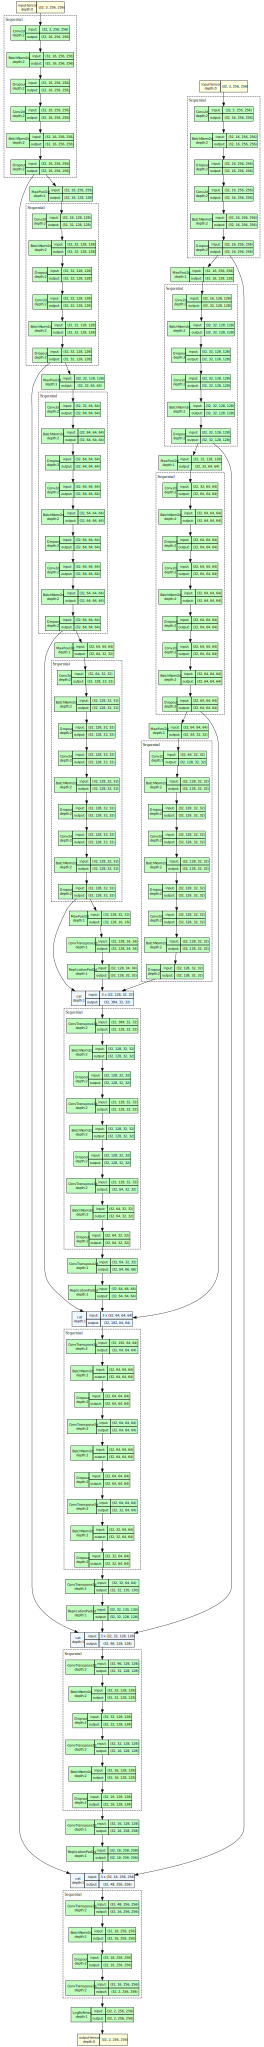

In [13]:
compiled.visual_graph([(32, 3, 256, 256), (32, 3, 256, 256)])

In [ ]:
w = torch.load('../../data/class_weight.pt')
w

In [14]:
results = compiled.train(train_dataloader,
                         nn.NLLLoss(torch.FloatTensor([0.0962, 0.2]).cuda()),
                         100,
                         test_dataloader,
                         multi_in=True
                         )

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0/100
train loss: 0.9806177549892001
val loss: 0.882027248541514
Epoch: 1/100
train loss: 0.8196119798554314
val loss: 0.689956267674764
Epoch: 2/100
train loss: 0.7707517610655891
val loss: 0.7085981766382853
Epoch: 3/100
train loss: 0.7323379847738478
val loss: 0.5879276593526205
Epoch: 4/100
train loss: 0.695568773481581
val loss: 0.7445664405822754
Epoch: 5/100
train loss: 0.6623890731069777
val loss: 0.6796964009602865
Epoch: 6/100
train loss: 0.606773747338189
val loss: 0.4871579706668854
Epoch: 7/100
train loss: 0.5585778024461534
val loss: 0.45833857854207355
Epoch: 8/100
train loss: 0.512534436252382
val loss: 0.4558884799480438
Epoch: 9/100
train loss: 0.4735602107312944
val loss: 0.5012863477071127
Epoch: 10/100
train loss: 0.4391186734040578
val loss: 0.3732811212539673
Epoch: 11/100
train loss: 0.40948494606547886
val loss: 0.391426940759023
Epoch: 12/100
train loss: 0.37419968181186253
val loss: 0.3123595615228017
Epoch: 13/100
train loss: 0.3620414700773027
val lo

In [79]:
# restore best checkpoint
state = torch.load("./last-checkpoint.pth")
model.load_state_dict(state['model_state_dict'])

<All keys matched successfully>

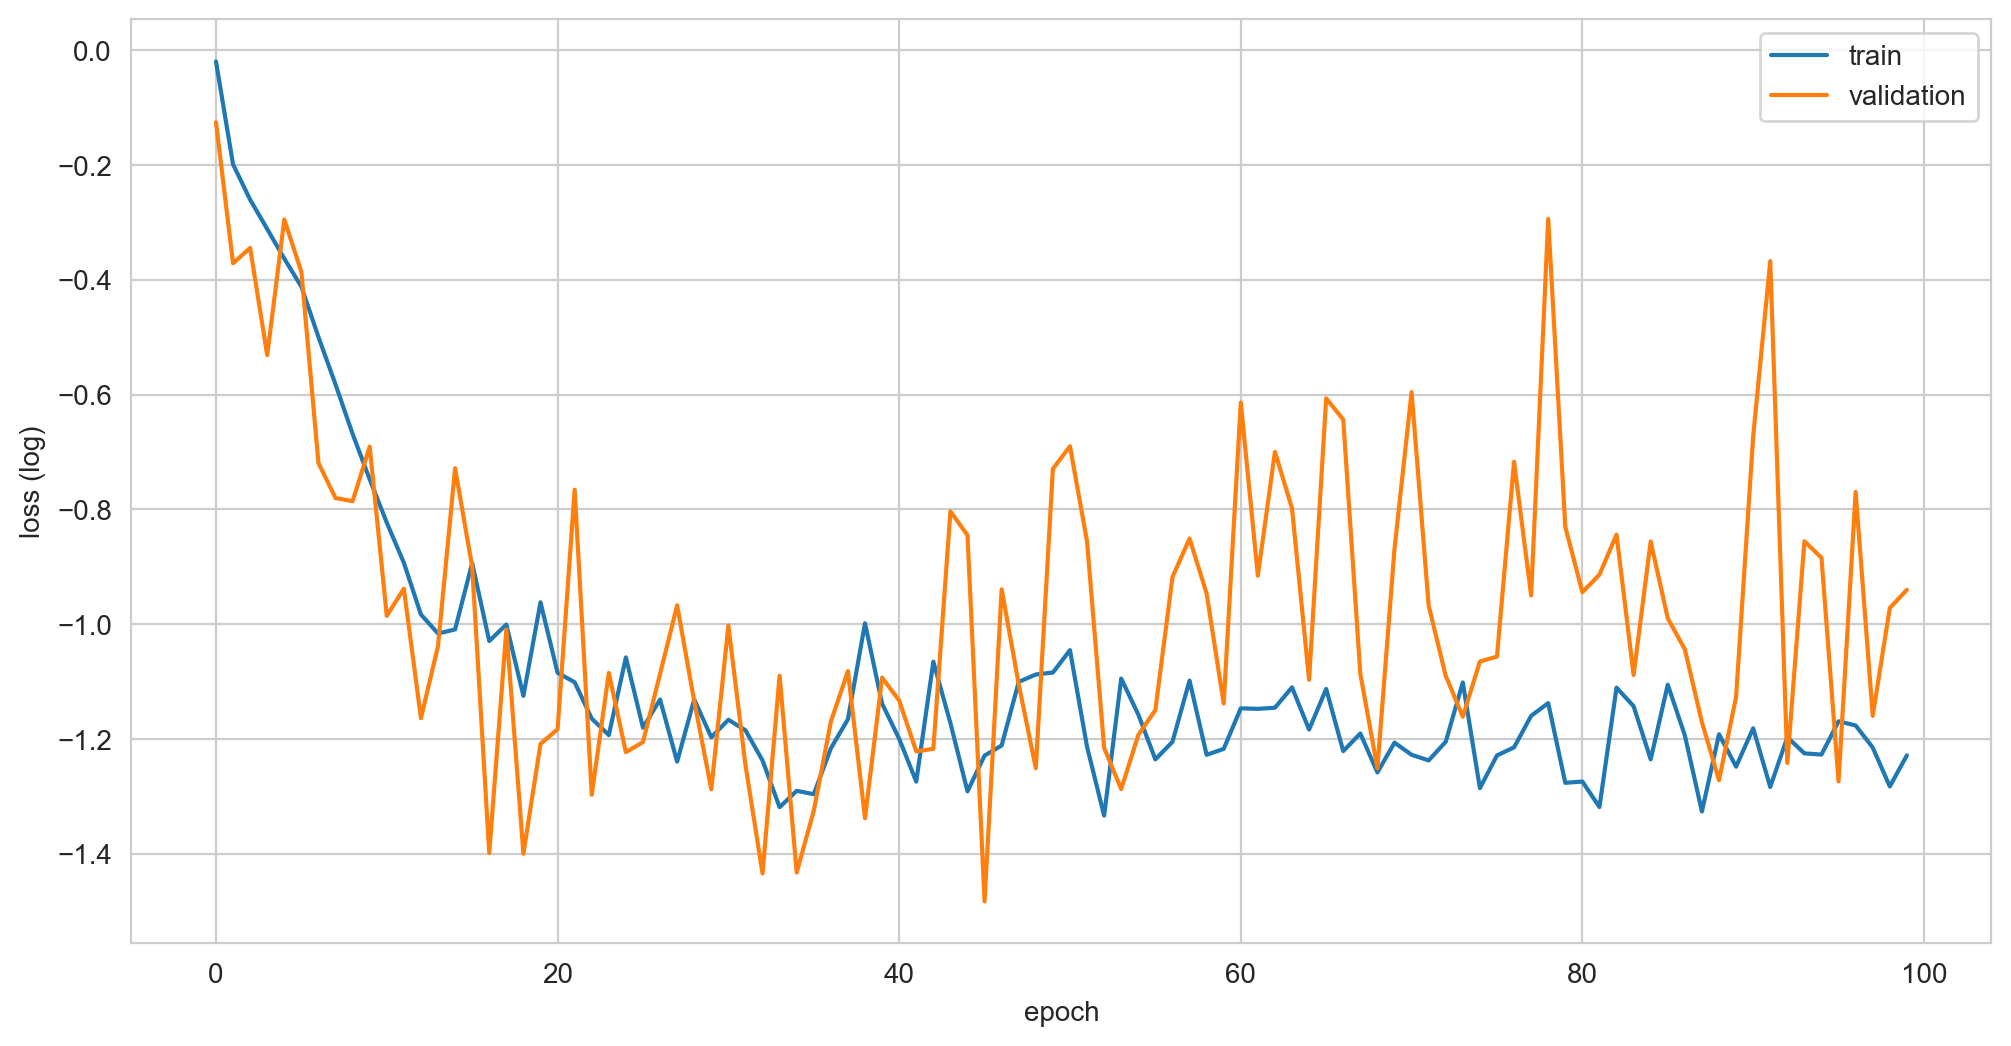

In [15]:
plt.figure(figsize=(12, 6), dpi=200)
sns.lineplot(x=results['epoch'], y=np.log(results['train loss']), label='train')
sns.lineplot(x=results['epoch'], y=np.log(results['val loss']), label='validation')
plt.ylabel('loss (log)')
plt.show()

In [17]:
acc_test = 0
kappa_test = 0
dice_test = 0
recall_test = 0
precision_test = 0

for img, gt in tqdm(test_dataset):
    with torch.no_grad():
        model.eval()
        logits = model(img[0].unsqueeze(0).to('cuda'),
                       img[1].unsqueeze(0).to('cuda'))[0].cpu()
        pred = torch.argmax(torch.sigmoid(logits), dim=0)

    acc_test += pixel_accuracy(gt, pred)
    kappa_test += precision(gt, pred)
    dice_test += dice(gt, pred)
    recall_test += recall(gt, pred)
    precision_test += precision(gt, pred)

print(acc_test / len(test_dataset),
      kappa_test / len(test_dataset),
      dice_test / len(test_dataset),
      recall_test / len(test_dataset),
      precision_test / len(test_dataset))

  0%|          | 0/67 [00:00<?, ?it/s]

tensor(0.8833) tensor(nan) tensor(nan) tensor(nan) tensor(nan)


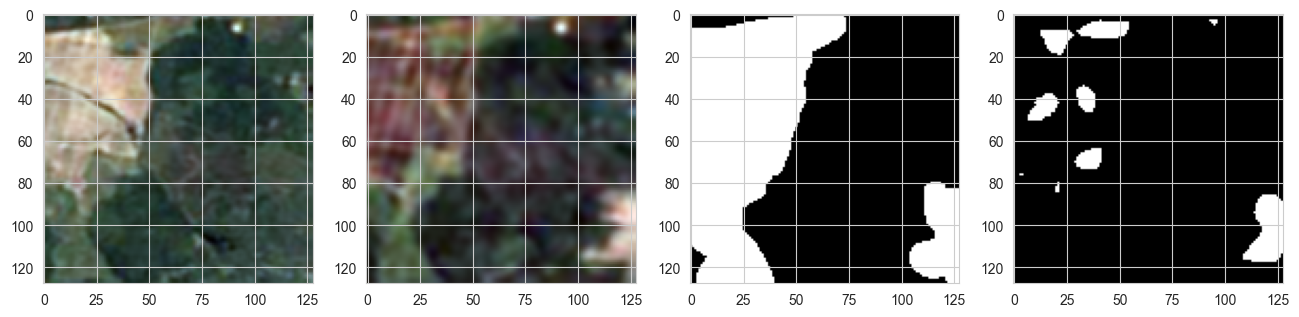

In [33]:
img, gt = test_dataset[np.random.randint(0, len(test_dataset))]

with torch.no_grad():
    model.eval()
    logits = model(img[0].unsqueeze(0).to('cuda'),
                   img[1].unsqueeze(0).to('cuda'))[0].cpu()
    pred = torch.argmax(torch.sigmoid(logits), dim=0)

plt.figure(figsize=(16, 10))
plt.subplot(1, 4, 1)
plt.imshow(img[0].permute(1, 2, 0), cmap='gray')
plt.subplot(1, 4, 3)
plt.imshow(gt, cmap='gray')
plt.subplot(1, 4, 2)
plt.imshow(img[1].permute(1, 2, 0), cmap='gray')
plt.subplot(1, 4, 4)
plt.imshow(pred, cmap='gray')